In [1]:
import json
import pathlib

import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np

In [2]:
!mkdir -p img

plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "sans-serif",
        "figure.figsize": (3, 2.5),
        "figure.dpi": 140,
    }
)

In [3]:
def load_trajectories_data(file_name=None, path=None):
    path = pathlib.Path().resolve().parent if path is None else pathlib.Path(path)
    file_name = path / file_name
    assert file_name.is_file(), file_name

    trajectories = json.load(open(file_name, "r"))["trajectories"]
    return [np.array(trj) for trj in trajectories]


TRAJECTORIES = {
    "p": load_trajectories_data("p.json"),
    "q": load_trajectories_data("q.json"),
}
len(TRAJECTORIES["p"]), len(TRAJECTORIES["q"]), TRAJECTORIES["q"][0].shape

(1024, 1, (1024, 2))

In [4]:
TEST_TRAJECTORIES = {
    "p": np.array([[[0, 0], [3, 4], [7, 4], [7, 8], [5, 3], [9, 3], [11, 5]]]),
    "q": np.array([[[3, 0], [1, 6], [9, 6], [11, 8]]]),
}

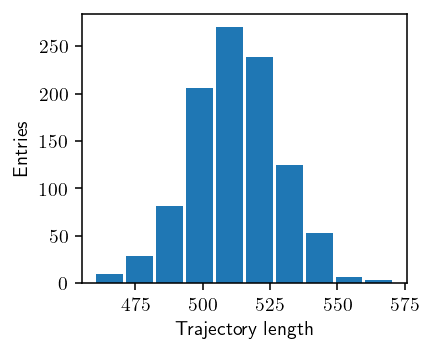

In [5]:
def plot_length(p):
    n = [trj.shape[0] for trj in p]

    fig, ax = plt.subplots()
    ax.hist(n, rwidth=0.9)
    ax.set_xlabel("Trajectory length")
    ax.set_ylabel("Entries")

    fig.savefig("img/trj_length.png")


plot_length(TRAJECTORIES["p"])

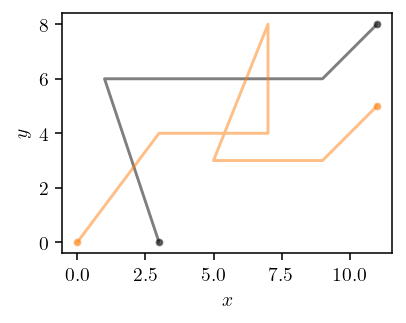

In [6]:
def plot_trajectories(p, q, *, p_idx, show_legend=False):
    fig, ax = plt.subplots()

    qx, qy = q[0].T
    ax.plot(qx[0], qy[0], "k.", alpha=0.5)
    ax.plot(qx[-1], qy[-1], "k.", alpha=0.5)
    ax.plot(qx, qy, "k", alpha=0.5, label="$q$")

    for n, i in enumerate(p_idx, start=1):
        px, py = p[i].T
        ax.plot(px[0], py[0], f"C{n}.", alpha=0.5)
        ax.plot(px[-1], py[-1], f"C{n}.", alpha=0.5)
        ax.plot(px, py, f"C{n}-", alpha=0.5, label=f"$p_{i}$")

    ax.set_aspect("equal")
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")

    if show_legend:
        ax.legend()

    fig.tight_layout()
    fig.savefig("img/trajectories.png")


plot_trajectories(TEST_TRAJECTORIES["p"], TEST_TRAJECTORIES["q"], p_idx=[0])

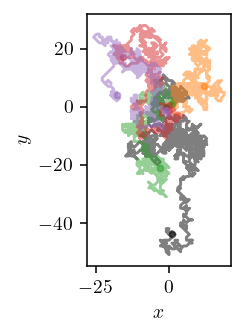

In [7]:
plot_trajectories(TRAJECTORIES["p"], TRAJECTORIES["q"], p_idx=[0, 1, 2, 3])

In [8]:
def interpolate(points, *, n):
    t = np.linspace(0, 1, n, endpoint=False)[:, np.newaxis]
    return np.concatenate(
        [a + (b - a) * t for a, b in zip(points[:-1], points[1:])]
        + [np.array([points[-1]])]
    )


def metric(p, q):
    px, py = p.T
    qx, qy = q.T

    return np.hypot(np.subtract.outer(px, qx), np.subtract.outer(py, qy))

In [9]:
def frechet_distance(d):
    P, Q = d.shape

    d = np.copy(d)
    d[:, 0] = np.maximum.accumulate(d[:, 0])
    d[0, :] = np.maximum.accumulate(d[0, :])

    path = np.zeros((P, Q, 2), dtype=np.int64)
    path[1:, 0, 0] = np.arange(P - 1)
    path[0, 1:, 1] = np.arange(Q - 1)

    for i in range(1, P):
        for j in range(1, Q):
            idx = np.array([[i - 1, j], [i - 1, j - 1], [i, j - 1]])

            min_idx = np.argmin(d[*idx.T])
            min_idx = idx[min_idx]

            d[i, j] = max(d[*min_idx], d[i, j])
            path[i, j] = min_idx

    optimal_path = [np.array([P - 1, Q - 1])]
    while not np.all(optimal_path[-1] == np.array([0, 0])):
        optimal_path.append(path[*optimal_path[-1]])

    optimal_path = np.stack(optimal_path[::-1]).astype(np.float64)

    return d[-1, -1], optimal_path / optimal_path[-1]

fd=3.000266654815868


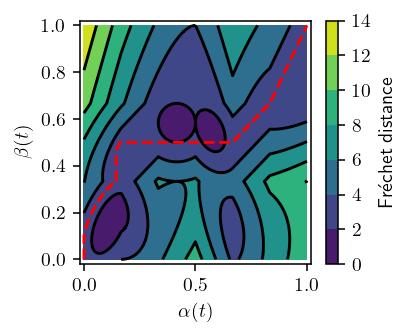

In [10]:
def plot_distance(p, q, *, p_idx=None, show_path=True, n=1):
    if p_idx is not None:
        p = p[p_idx]

    p = interpolate(p, n=n)
    q = interpolate(q, n=n)
    d = metric(p, q)

    fd, path = frechet_distance(d)
    print(f"{fd=}")

    tp = np.linspace(0, 1, d.shape[0])
    tq = np.linspace(0, 1, d.shape[1])
    x, y = np.meshgrid(tp, tq)
    z = d.T

    fig, ax = plt.subplots()
    cset = ax.contourf(x, y, z)
    ax.contour(x, y, z, cset.levels, colors="k")
    cbar = fig.colorbar(cset)

    if show_path:
        ax.plot(path[:, 0], path[:, 1], "--", color="red")

    ax.set_xlim(-0.02, 1.02)
    ax.set_ylim(-0.02, 1.02)

    ax.set_xlabel(r"$\alpha(t)$" if p_idx is None else r"$\alpha_{" + str(p_idx) + "}(t)$")
    ax.set_ylabel(r"$\beta(t)$")
    cbar.set_label(r"Fr\'echet distance")

    fig.tight_layout()
    fig.savefig("img/distance.png")


plot_distance(TEST_TRAJECTORIES["p"][0], TEST_TRAJECTORIES["q"][0], n=100)

fd=5.0


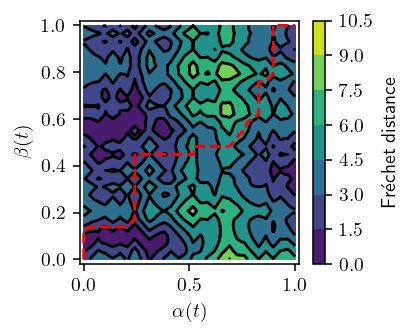

In [11]:
plot_distance(TRAJECTORIES["p"][0][:30], TRAJECTORIES["q"][0][:30], n=10)

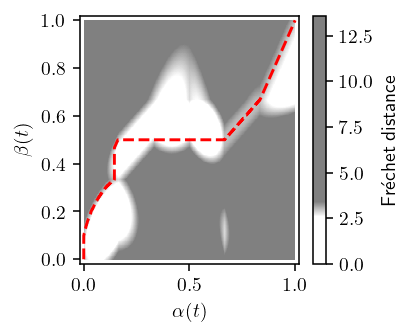

In [12]:
def plot_freespace(p, q, *, p_idx=None, threshold=None, show_path=True, n=1):
    if p_idx is not None:
        p = p[p_idx]

    p = interpolate(p, n=n)
    q = interpolate(q, n=n)
    d = metric(p, q)

    fd, path = frechet_distance(d)
    if threshold is None:
        threshold = fd

    tp = np.linspace(0, 1, d.shape[0])
    tq = np.linspace(0, 1, d.shape[1])
    x, y = np.meshgrid(tp, tq)
    z = d.T

    fig, ax = plt.subplots()

    norm = mpl.colors.Normalize(vmin=np.min(z), vmax=np.max(z))
    thr = norm(threshold)
    sdata = [
        [0.0, 1.0, 1.0],
        [thr - 0.03, 1.0, 1.0],
        [thr + 0.03, 0.5, 0.5],
        [1.0, 0.5, 0.5],
    ]
    my_cmap = mpl.colors.LinearSegmentedColormap(
        "my_cmap",
        segmentdata={"red": sdata, "green": sdata, "blue": sdata},
        N=1024,
    )
    cset = ax.pcolormesh(x, y, z, cmap=my_cmap, norm=norm)
    cbar = fig.colorbar(cset)

    if show_path:
        ax.plot(path[:, 0], path[:, 1], "--", color="red")

    ax.set_xlim(-0.02, 1.02)
    ax.set_ylim(-0.02, 1.02)

    ax.set_xlabel(r"$\alpha(t)$" if p_idx is None else "$\alpha_{" + str(p_idx) + "}(t)$")
    ax.set_ylabel(r"$\beta(t)$")
    cbar.set_label(r"Fr\'echet distance")

    fig.tight_layout()
    fig.savefig("img/freespace.png")


plot_freespace(TEST_TRAJECTORIES["p"][0], TEST_TRAJECTORIES["q"][0], n=100)

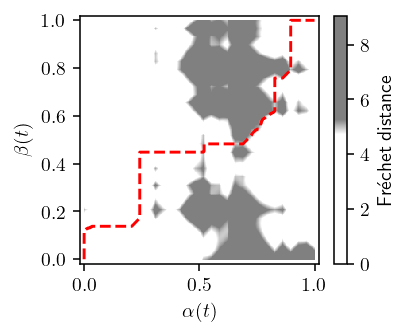

In [13]:
plot_freespace(TRAJECTORIES["p"][0][:30], TRAJECTORIES["q"][0][:30], n=10)